In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import pywt

Using TensorFlow backend.


In [17]:
raw = pd.read_csv("../data/BTC/BTC_Book_0.zip", compression = 'zip', parse_dates = True, index_col = 0)

#reorder data sets
prices = raw[raw.columns[1::3]]
p_cols = list(np.flip(prices.columns.values[:50])) + list(prices.columns.values[50:])
prices = prices[p_cols]

sizes = raw[raw.columns[2::3]]
s_cols = list(np.flip(sizes.columns.values[:50])) + list(sizes.columns.values[50:])
sizes = sizes[s_cols]

trades = raw[raw.columns[3::3]]
t_cols = list(np.flip(trades.columns.values[:50])) + list(trades.columns.values[50:])
trades = trades[t_cols]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

time_slices = rolling_window(prices.values, 30)
print(time_slices.shape)

new_slices = np.zeros(time_slices.shape)

time_scaler = MinMaxScaler(feature_range=(0,1))
for i in range(time_slices.shape[0]):
  img = time_slices[i]
  time_scaler.fit(img)
  img_tr = time_scaler.transform(img)
  new_slices[i,:,:] = img_tr.copy()


plt.imshow(new_slices[0])

(50000,)
(50000,)
(50000,)


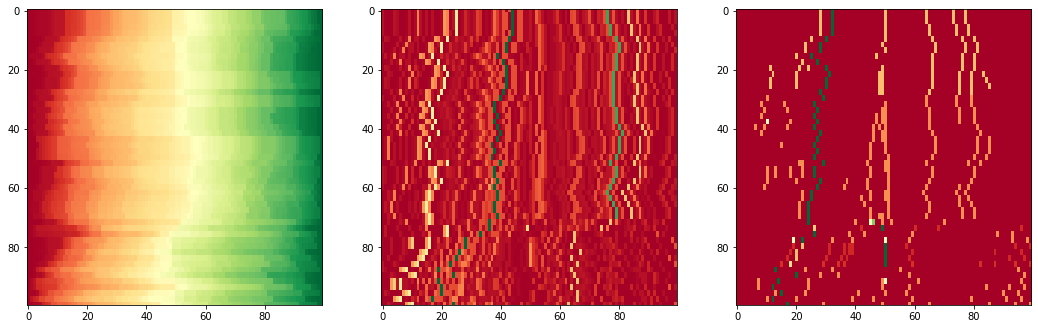

In [18]:
from sklearn.preprocessing import MinMaxScaler

#scale prices
p_scaler = MinMaxScaler(feature_range=(0,1))
p_scaler.fit(prices.T)
print(p_scaler.min_.shape)
price_tr = p_scaler.transform(prices.T).T

#scale sizes
s_scaler = MinMaxScaler(feature_range=(0,1))
s_scaler.fit(sizes.T)
print(s_scaler.min_.shape)
size_tr = s_scaler.transform(sizes.T).T

#scale trades
t_scaler = MinMaxScaler(feature_range=(0,1))
t_scaler.fit(trades.T)
print(t_scaler.min_.shape)
trade_tr = t_scaler.transform(trades.T).T


#plot example
start = 0
window = 100
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 6))
ax[0].imshow(price_tr[start:start + window], cmap = 'RdYlGn')
ax[1].imshow(size_tr[start:start + window], cmap = 'RdYlGn')
ax[2].imshow(trade_tr[start:start + window], cmap = 'RdYlGn')

In [19]:
#setting up X for training
def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

price_roll = rolling_window(price_tr, 100)
size_roll = rolling_window(size_tr, 100)
trade_roll = rolling_window(trade_tr, 100)

total = np.stack((price_roll, size_roll, trade_roll),axis = -1)
total.shape

(49901, 100, 100, 3)

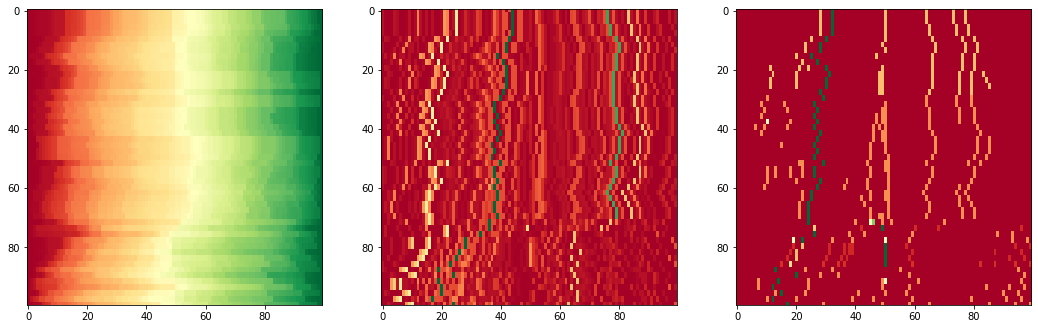

In [20]:
start = 0
window = 100
sample = 0
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 6))
ax[0].imshow(total[sample][:,:,0], cmap = 'RdYlGn')
ax[1].imshow(total[sample][:,:,1], cmap = 'RdYlGn')
ax[2].imshow(total[sample][:,:,2], cmap = 'RdYlGn')

In [21]:
#Setting up Targets for training
from sklearn.preprocessing import OneHotEncoder

mid_price = pd.DataFrame((prices['Bid_1_Price'] + prices['Ask_1_Price'])/2 ,columns = ['mid_price'])
mid_price['target'] = mid_price['mid_price'].diff(1).shift(-1)

def return_cat(x):
    if x == 0:
        return 0
    if x > 0:
        return 1
    if x < 0:
        return -1

mid_price['target_cat'] = mid_price['target'].apply(return_cat) #not NAN for indices 0 - 49998 - last is nan
mid_price = mid_price.dropna()
    
encoder = OneHotEncoder()
encoder.fit(mid_price['target_cat'].values.reshape(-1,1))
target_one_hot = encoder.transform(mid_price['target_cat'].values.reshape(-1,1)).toarray()
print(target_one_hot.shape)
target_one_hot

(49999, 3)


array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [22]:
#Setting Train Sets
X = total[:len(total)-1] #remove last since no prediction
print(X.shape)

Y = target_one_hot[99:] #no predictions for indicies 0 -> 98 (99 steps), index 99 has first 1 step ahead
print(Y.shape)

X_train = X[:40000]
Y_train = Y[:40000]

X_test = X[40000:]
Y_test = Y[40000:]

(49900, 100, 100, 3)
(49900, 3)


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

def build_cnn_model(activation, input_shape):
    model = Sequential()
    
    # 2 Convolution layer with Max polling
    model.add(Conv2D(32, 5, activation = activation, padding = 'same', input_shape = input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D())  
    model.add(Flatten())
    
    # 3 Full connected layer
    model.add(Dense(128, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(54, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(3, activation = 'softmax')) # 3 classes
    
    # summarize the model
    print(model.summary())
    return model

def compile_and_fit_model(model, X_train, y_train, X_test, y_test, batch_size, n_epochs):

    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'])
#         loss='sparse_categorical_crossentropy',
#         metrics=['sparse_categorical_accuracy'])
    
    # define callbacks
    callbacks = [ModelCheckpoint(filepath='best_model1.h5', monitor='val_categorical_accuracy', save_best_only=True)]
    
    # fit the model
    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))
    
    return model, history

# shape of the input images
input_shape = (X.shape[1], X.shape[2], X.shape[3])

# create cnn model
cnn_model = build_cnn_model("relu", input_shape)
# train cnn model
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train, Y_train, X_test, Y_test, 100, 10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5120128   
_________________________________________________________________
dense_2 (Dense)              (None, 54)               

In [10]:
# serialize model to JSON
model_json = trained_cnn_model.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
trained_cnn_model.save_weights("cnn_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
 
# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [23]:
import seaborn as sns
from sklearn import metrics

def create_confusion_matrix(y_pred, y_test):    
    #calculate the confusion matrix
    confmat = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(confmat, cmap=plt.cm.Blues, alpha=0.5)

    n_labels = 3
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
#     ax.set_xticklabels(LABEL_NAMES)
#     ax.set_yticklabels(LABEL_NAMES)

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # loop over data dimensions and create text annotations.
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center')
    
    # avoid that the first and last row cut in half
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

# # make predictions for test data
y_pred = trained_cnn_model.predict_classes(X_test)
# determine the total accuracy 
accuracy = metrics.accuracy_score(Y_test.argmax(axis=1), y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

create_confusion_matrix(y_pred, Y_test.argmax(axis=1))

NameError: name 'trained_cnn_model' is not defined

Loaded model from disk
Accuracy: 81.20%


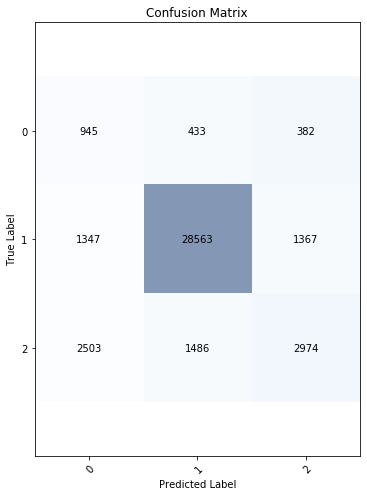

In [24]:
from keras.models import model_from_json
from sklearn import metrics

# load json and create model
json_file = open('cnn_model_trained.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'])

y_pred = loaded_model.predict_classes(X_train)
# determine the total accuracy 
accuracy = metrics.accuracy_score(Y_train.argmax(axis=1), y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

create_confusion_matrix(y_pred, Y_train.argmax(axis=1))


### Wrong

[[  945.  1347.  2503.]
 [  433. 28563.  1486.]
 [  382.  1367.  2974.]]


Text(51.0, 0.5, 'True Label')

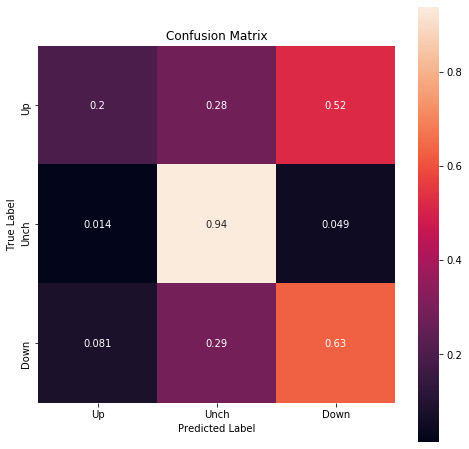

In [25]:
from keras.models import model_from_json

# load json and create model
json_file = open('cnn_model_trained.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'])

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(Y_train,1), np.argmax(loaded_model.predict(X_train),1))
cm = cm.astype(float)

print(cm)

cm[0,:] = np.true_divide(cm[0,:], cm[0,:].sum())
cm[1,:] = np.true_divide(cm[1,:], cm[1,:].sum())
cm[2,:] = np.true_divide(cm[2,:], cm[2,:].sum())


import seaborn as sns

fig, axs = plt.subplots(1, figsize = (8,8))
axs = sns.heatmap(cm, xticklabels=['Up','Unch', 'Down'], 
                  yticklabels=['Up','Unch', 'Down'], annot = True,square=True)
axs.set_title("Confusion Matrix")
axs.set_xlabel('Predicted Label')
axs.set_ylabel('True Label')